# Abstraction and Reasoning Starter Notebook

This notebook will get you started on on the basics of this competition

In [1]:
import numpy as np
import pandas as pd

import os
import json
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import colors

In [3]:
for dirname, _, filenames in os.walk('./kaggle_input'):
    print(dirname)

./kaggle_input
./kaggle_input/test
./kaggle_input/training
./kaggle_input/evaluation


Use the `Path` class for paths.

In [7]:
data_path = Path('./kaggle_input/')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
test_path = data_path / 'test'

The `training` folder has 400 JSON tasks. The names of the first three are shown below.

In [9]:
training_tasks = sorted(os.listdir(training_path))
print(training_tasks[1:4])

['007bbfb7.json', '00d62c1b.json', '017c7c7b.json']


In each task, there are two dictionary keys, `train` and `test`. You learn the pattern from the train input-output pairs, and then apply the pattern to the `test` input, to predict an output.

In [19]:
task_file = str(training_path / '017c7c7b.json')

with open(task_file, 'r') as f:
    task = json.load(f)

print(task.keys())

dict_keys(['train', 'test'])


Tasks have multiple `train` input-output pairs. Most tasks have a single `test` input-output pair, although some have more than one.

In [20]:
n_train_pairs = len(task['train'])
n_test_pairs = len(task['test'])

print(f'task contains {n_train_pairs} training pairs')
print(f'task contains {n_test_pairs} test pairs')

task contains 3 training pairs
task contains 1 test pairs


Drilling into the first `train` input-output pair, we can see the grids are expressed as 2d lists with integers 0-9.

In [21]:
display(task['train'][0]['input'])
display(task['train'][0]['output'])

[[0, 1, 0], [1, 1, 0], [0, 1, 0], [0, 1, 1], [0, 1, 0], [1, 1, 0]]

[[0, 2, 0],
 [2, 2, 0],
 [0, 2, 0],
 [0, 2, 2],
 [0, 2, 0],
 [2, 2, 0],
 [0, 2, 0],
 [0, 2, 2],
 [0, 2, 0]]

## Function to plot the first train/test input/output pairs of a task

You can use this function to plot the first `train` and `test` grids. The color aligns with what is found on the ARC app. Note though, the ARC app presents the grids to scale, where these display the grids in the same size, regardless of their dimension.

In [22]:
def plot_task(task):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, 4, figsize=(15,15))
    axs[0].imshow(task['train'][0]['input'], cmap=cmap, norm=norm)
    axs[0].axis('off')
    axs[0].set_title('Train Input')
    axs[1].imshow(task['train'][0]['output'], cmap=cmap, norm=norm)
    axs[1].axis('off')
    axs[1].set_title('Train Output')
    axs[2].imshow(task['test'][0]['input'], cmap=cmap, norm=norm)
    axs[2].axis('off')
    axs[2].set_title('Test Input')
    axs[3].imshow(task['test'][0]['output'], cmap=cmap, norm=norm)
    axs[3].axis('off')
    axs[3].set_title('Test Output')
    plt.tight_layout()
    plt.show()

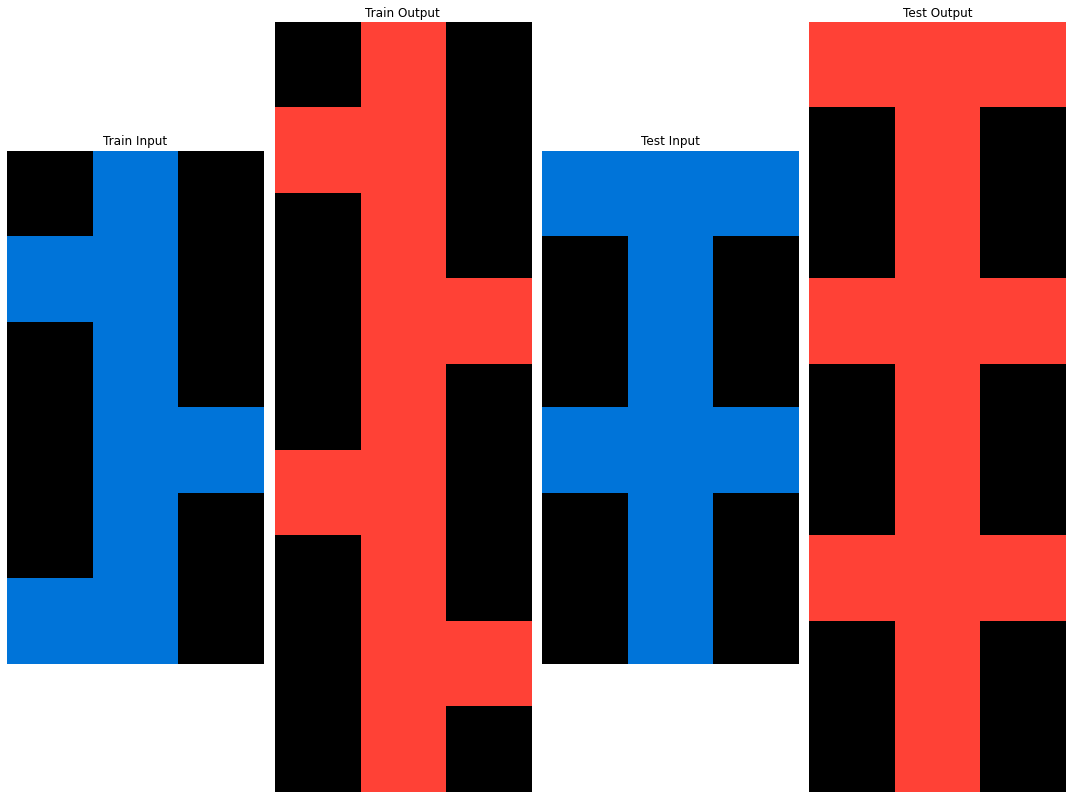

In [23]:
plot_task(task)

# Using the correct prediction format

In [15]:
submission = pd.read_csv(data_path / 'sample_submission.csv', index_col='output_id')
display(submission.head())

,output
output_id,
00576224_0,|32|78| |32|78| |00|00|
009d5c81_0,|00000000000000|00000888888888|00000800080808|...
00dbd492_0,|00000000000222220000|02222222220200020000|020...
03560426_0,|0000000000|0000000000|0000000000|0000000000|0...
05a7bcf2_0,|000000000020000000080000000000|00000000002220...


The `output_id` is the `id` of the task, followed by the index of the `test` input that you should use to make your prediction. The `output` is the predicted output of the corresponding `test` input, reformatted into a string representation. (You can make three predictions per `output_id`, delineated by a space.) Use the following function to convert from a 2d python list to the string representation.

In [16]:
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

In [17]:
example_grid = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
display(example_grid)
print(flattener(example_grid))

[[1, 2, 3], [4, 5, 6], [7, 8, 9]]

|123|456|789|


# Re-creating the sample submission output

This demonstrates how to loop over the sample submission and make predictions.

In [18]:
for output_id in submission.index:
    task_id = output_id.split('_')[0]
    pair_id = int(output_id.split('_')[1])
    f = str(test_path / str(task_id + '.json'))
    with open(f, 'r') as read_file:
        task = json.load(read_file)
    # skipping over the training examples, since this will be naive predictions
    # we will use the test input grid as the base, and make some modifications
    data = task['test'][pair_id]['input'] # test pair input
    # for the first guess, predict that output is unchanged
    pred_1 = flattener(data)
    # for the second guess, change all 0s to 5s
    data = [[5 if i==0 else i for i in j] for j in data]
    pred_2 = flattener(data)
    # for the last gues, change everything to 0
    data = [[0 for i in j] for j in data]
    pred_3 = flattener(data)
    # concatenate and add to the submission output
    pred = pred_1 + ' ' + pred_2 + ' ' + pred_3 + ' ' 
    submission.loc[output_id, 'output'] = pred

submission.to_csv('submission.csv')